# First Attempt with Keras

Let's have a play around and see what I can do. Let's just build a nice simple model, using the medium article as a follow along. 

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import StandardScaler, MinMaxScaler
min_max = MinMaxScaler()
scaler = StandardScaler()

DOWNLOAD_DIR = Path('../download')

In [13]:
sns.set()

In [9]:
price = pd.read_csv(DOWNLOAD_DIR / 'price.csv')
close = price.loc[:, 'c']

In [15]:
close.tail()

92969    47437.266848
92970    47332.765754
92971    47410.123970
92972    45889.364858
92973    47467.739097
Name: c, dtype: float64

Let's take 1 year of data and use it to predict the next 30 days. 

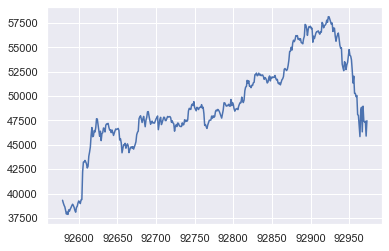

In [20]:
prediction_days = 30
one_year = 365
close[-365 - 30:].plot()

close_train = close[-one_year : -prediction_days]
close_test = close[-prediction_days:]

<AxesSubplot:>

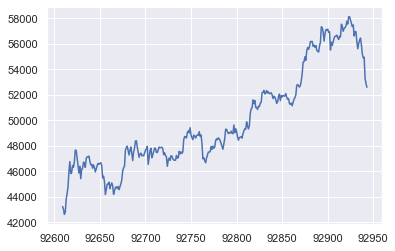

In [24]:
close_train.plot()

<AxesSubplot:>

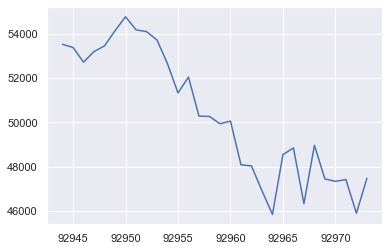

In [25]:
close_test.plot()

In [28]:
close_train.index[-1], close_test.index[0]

(92943, 92944)

In [56]:
# Prep for training
training_set = close_train.values.reshape(-1, 1)
training_set_std_scale = scaler.fit_transform(training_set)
training_set_min_max_scale = min_max.fit_transform(training_set)

In [57]:
# We are training to predict the next day's close
# so cut off final val for X_train and start at index 1 for
# y_train
X_train = training_set_std_scale[:-1]
y_train = training_set_std_scale[1:]
X_train = X_train.reshape((-1, 1, 1))

In [48]:
# Why did this not work?
input_tensor = Input(shape=(1,))
x = LSTM(4)(input_tensor)
x = LSTM(4)(x)
output_tensor = Dense(1)(x)

model = Model(input_tensor, output_tensor)

ValueError: Input 0 of layer lstm is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 1]

In [58]:
regressor = Sequential([
    LSTM(4),
    Dense(1)
])
regressor.compile(optimizer='adam', loss='mean_squared_error')
history = regressor.fit(X_train, y_train, batch_size=5, epochs=100)

Train on 334 samples
Epoch 1/100
334/334 [==============================] - 3s 9ms/sample - loss: 0.8680
Epoch 2/100
334/334 [==============================] - 0s 605us/sample - loss: 0.7666
Epoch 3/100
334/334 [==============================] - 0s 621us/sample - loss: 0.6338
Epoch 4/100
334/334 [==============================] - 0s 606us/sample - loss: 0.4836
Epoch 5/100
334/334 [==============================] - 0s 606us/sample - loss: 0.3416
Epoch 6/100
334/334 [==============================] - 0s 610us/sample - loss: 0.2234
Epoch 7/100
334/334 [==============================] - 0s 615us/sample - loss: 0.1363
Epoch 8/100
334/334 [==============================] - 0s 629us/sample - loss: 0.0810
Epoch 9/100
334/334 [==============================] - 0s 654us/sample - loss: 0.0493
Epoch 10/100
334/334 [==============================] - 0s 607us/sample - loss: 0.0340
Epoch 11/100
334/334 [==============================] - 0s 635us/sample - loss: 0.0270
Epoch 12/100
334/334 [===========

334/334 [==============================] - 0s 611us/sample - loss: 0.0121
Epoch 96/100
334/334 [==============================] - 0s 606us/sample - loss: 0.0120
Epoch 97/100
334/334 [==============================] - 0s 601us/sample - loss: 0.0121
Epoch 98/100
334/334 [==============================] - 0s 601us/sample - loss: 0.0120
Epoch 99/100
334/334 [==============================] - 0s 604us/sample - loss: 0.0120
Epoch 100/100
334/334 [==============================] - 0s 661us/sample - loss: 0.0121


In [59]:
testing_set = close_test.values.reshape((-1, 1))
testing_set = scaler.transform(testing_set)
testing_set = testing_set.reshape((-1, 1, 1))

In [60]:
predicted_price = regressor.predict(testing_set)
predicted_price = scaler.inverse_transform(predicted_price)

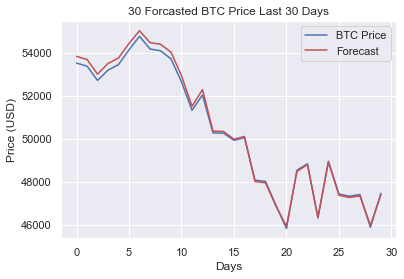

In [65]:
fig, ax = plt.subplots()
plt.plot(close_test.values, c='b', label='BTC Price')
plt.plot(predicted_price, c='r', label='Forecast')
plt.legend()
ax.set(xlabel='Days', ylabel='Price (USD)',
      title='30 Forcasted BTC Price Last 30 Days')
plt.show()